In [70]:
import numpy as np
import sys
import os
import fnmatch
sys.path.append('../')
import base as base
import path_analysis
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob
from scipy.stats import ttest_ind

In [3]:
root_path = '/mnt/c/Users/megla/OneDrive/Documents/TUM/RatAnalysis/Data/'

In [89]:
# Load data for visible, invisible, sham conditions

vis_data = np.load(os.path.join(root_path, glob.glob(os.path.join(root_path, '*_visible*.npy'))[0]))
invis_data = np.load(os.path.join(root_path, glob.glob(os.path.join(root_path, '*invisible*.npy'))[0]))
sham_data = np.load(os.path.join(root_path, glob.glob(os.path.join(root_path, '*shuffle*FS11*.npy'))[0]))

print(vis_data.shape)
print(invis_data.shape)
print(sham_data.shape)

# Crop the sham trajectory 
num_samples = vis_data.shape[1]
cropped_sham = sham_data[:, -num_samples:]

print(cropped_sham.shape)

(11, 260)
(11, 260)
(10000, 498)
(10000, 260)


In [90]:
# Calculate means
mean_vis = np.nanmean(vis_data, axis=0)
mean_invis = np.nanmean(invis_data, axis=0)
mean_sham = np.nanmean(cropped_sham, axis=0)

/tmp/ipykernel_788/2837794341.py:2: RuntimeWarning: Mean of empty slice
  mean_vis = np.nanmean(vis_data, axis=0)
/tmp/ipykernel_788/2837794341.py:3: RuntimeWarning: Mean of empty slice
  mean_invis = np.nanmean(invis_data, axis=0)


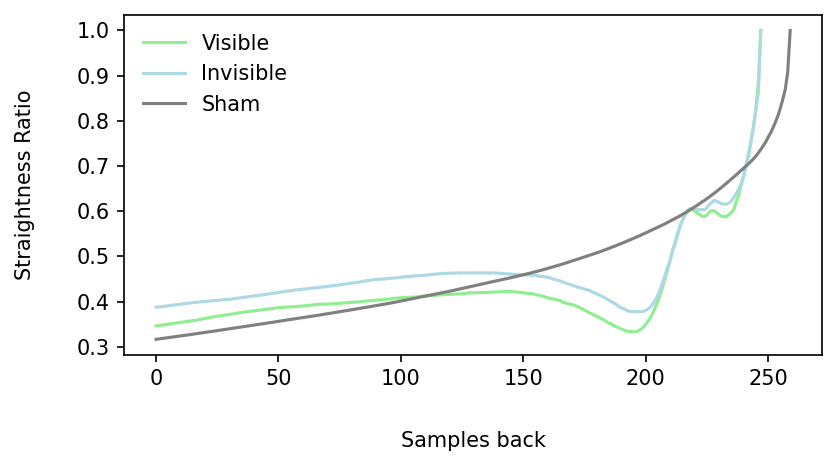

In [92]:
# Sample plot
plt.figure(dpi=150, figsize=(6,3))

plt.plot(mean_vis, label='Visible', c='lightgreen')
plt.plot(mean_invis, label='Invisible', c='lightblue')
plt.plot(mean_sham, label='Sham', c= 'grey')

plt.ylabel('Straightness Ratio', labelpad=20)
plt.xlabel('Samples back', labelpad=20)

plt.legend(frameon=False, fontsize=10)

plt.show()

In [93]:
# Because we have different numbers of samples in the Visible/Invisible vs. Sham groups, we need to use Welch's t-test
# (allows for unequal variances)

# First doing this on a sample point in time 
# Start by comparing the visble with the sham
sample_pt = 200

vis_sample = vis_data[:, sample_pt] # This is now shape (11,)
sham_sample = sham_data[:, sample_pt] # This is now shape (1000,)

tstat, pval = ttest_ind(vis_sample, sham_sample, equal_var= False)
print(pval)

0.00609459335233611


In [143]:
# We want to check the pvals on all of the timepoints and return the points that pass our significance threshold

def compute_pvals(real_data, sham_data, p_sig=0.05):
    
    ''' 
    Parameters
    
    real_data: Our straightness ratios for a set of invisble or visible trials; shape (ntrials, nsamples)
    sham_data: Bootstrapped data sampled from trajectories; shape (nbootstrapped, nsamples)
    p_sig: Our selected significance threshold
    
    Returns
    
    time_sig: array of values of timepoints (samples) where the mean straightness ratio passed the null hypothesis
        
    '''
    
    # Make sure both data arrays have the same number of samples (timepoints)
    assert real_data.shape[1] == sham_data.shape[1], "Ensure that your input data arrays the same number of samples!"
    
    num_samples = real_data.shape[1]
    sig_pts = []
    
    for i in range(num_samples): 
        
        tstat, pval = ttest_ind(real_data[:,i], sham_data[:,i], equal_var= False)
        if pval < p_sig: 
            sig_pts.append(i)
    
    return sig_pts

In [108]:
sig_times_vis = compute_pvals(vis_data, cropped_sham)
sig_times_invis = compute_pvals(invis_data, cropped_sham)

In [122]:
# Need to check if there are separate time ranges covered
print(np.unique(np.diff(sig_times_vis)))
print(np.unique(np.diff(sig_times_invis)))

change_idx = np.where(np.diff(sig_times_invis) > 1)[0][0]

[1]
[ 1 27]


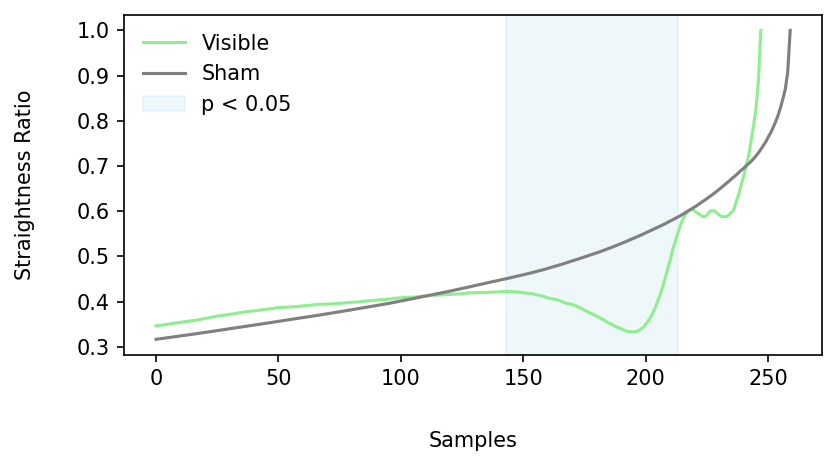

In [141]:
# Plot the straightness ratios again and shade the significant time points (this example for visible)

fig, ax = plt.subplots(dpi=150, figsize=(6,3))

plt.plot(mean_vis, label='Visible', c='lightgreen')
plt.plot(mean_sham, label='Sham', c= 'grey')

ax.axvspan(sig_times_vis[0], sig_times_vis[-1], alpha=0.2, color='lightblue', label='p < 0.05')

plt.ylabel('Straightness Ratio', labelpad=20)
plt.xlabel('Samples', labelpad=20)

plt.legend(frameon=False, fontsize=10)

plt.show()

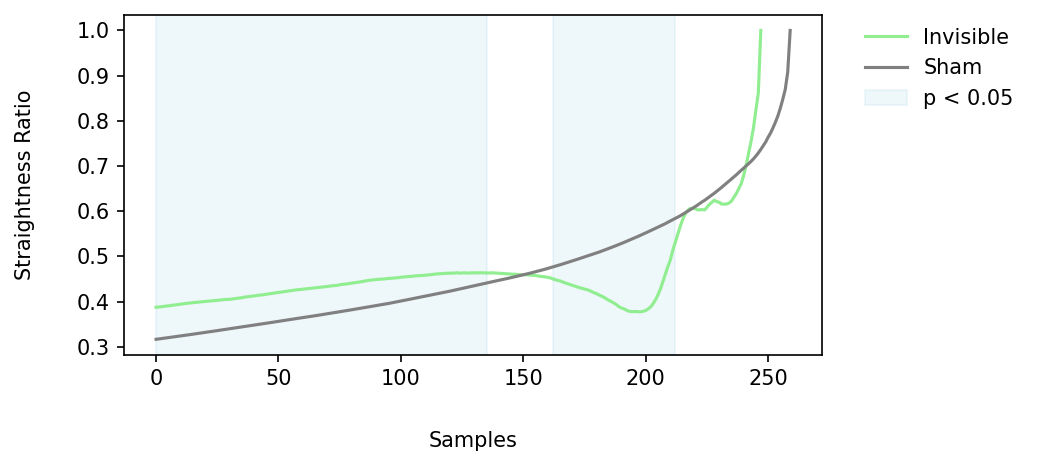

In [142]:
# Plot the straightness ratios again and shade the significant time points (this example for visible)

fig, ax = plt.subplots(dpi=150, figsize=(6,3))

plt.plot(mean_invis, label='Invisible', c='lightgreen')
plt.plot(mean_sham, label='Sham', c= 'grey')

ax.axvspan(sig_times_invis[0], sig_times_invis[change_idx], alpha=0.2, color='lightblue', label='p < 0.05')
ax.axvspan(sig_times_invis[change_idx+1], sig_times_invis[-1], alpha=0.2, color='lightblue')

plt.ylabel('Straightness Ratio', labelpad=20)
plt.xlabel('Samples', labelpad=20)

plt.legend(frameon=False, fontsize=10, loc=[1.05, 0.7])

plt.show()